# Baseline Model 

## Goals

We aim to create a simple baseline model to classify the *FULL DATASET*. This model will be a 1-hidden-layer fully-connected MLP. Inputs will be comprised of (1) energy distribution over time or (2) frequency distribution. 

These two approaches will give a sense of the information contained in each axis of the time-frequency plane when considered independently. 

## Data Logistics

Data is located in `../Full_Dataset/Spectrograms/` in 6 separate folders (one per gesture). The generation code can be found in `../Feature_Extraction/Feature Extractor.ipynb`.

## Feature Extraction/Pre-Processing

The primary operation on the input arrays will be to take the sum across one of the two dimensions of each bitmap. For the energy distribution, columns will be summed, and for the frequency distribution, the rows will be summed. 

There will be another optional step of *downsampling*. A function to accomplish this will be copied from `../Prototype_Models`, either `Data_Segmentation_Energy.ipynb` or `Simple_Classifier.ipynb`.

## Classification

See `../Prototype_Models/Simple_Classifier`. 

## Tasks

- [x] Import all numpy array bitmaps for each class. 
- [x] Create energy distribution calculator (dissect central portion for those longer than 0.75 seconds).
    - [x] Get list of energy distributions.
- [ ] Create frequency distribution calculator (length doesn't matter here!).
    - [ ] Get list of frequency distributions.
- [ ] Format lists of energy/frequency distributions into proper data types.
- [ ] Perform data split. 
- [ ] Train classifier (see `../Prototype_Models/Simple_Classifier`).
- [ ] Test classifier.
- [ ] Display model statistics.

In [1]:
# IMPORT BOX #
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas
from scipy.io import wavfile
import scipy.io

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix

In [2]:
"""Constants"""

base_path = '../Full_Dataset/Spectrograms/'

folders = ['Circle_Scratches',
 'Fingernail_Taps',
 'Fingertip_Taps',
 'Silences',
 'Vertical_Scratches',
 'W_Scratches']

seg_lens = [1, 0.75, 0.75, 0.75, 0.75, 1.5] # length in seconds of
                                            # each sample type.

FS_global = 44100 # Global value for sampling rate (set in DAW)

In [3]:
def get_file_list(base_path, folder_name):
    """
    Gets a list of file names (strings) in the basepath/folder_name/ 
    directory.
    """
    path = base_path + folder_name
    stream = os.popen('ls {}'.format(path))
    output = stream.read()
    file_names = output.split('\n')[:-1]
    return file_names

In [4]:
def get_all_imgs(pth, names):
    """
    Given a base path and a list of `names`, returns a list of 
    numpy array bitmaps for each file in `pth/name` in `names`.
    """
    ret_val = []
    
    for name in names:
        im = plt.imread(pth+'/'+name)[:,:,0]
        ret_val.append(im)
        
    return ret_val
        

Shape of test image: (100, 87)


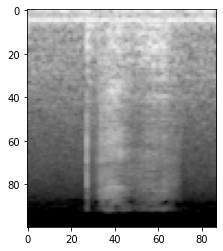

In [5]:
"""Test Image Retrieval"""

test_image = plt.imread(base_path+folders[0]+'/1.png')[:,:,0]
print("Shape of test image: {}".format(test_image.shape))
plt.imshow(test_image, cmap='gray')
plt.show()

In [6]:
def get_energy(bitmap, section_len=65):
    """Crops an input bitmap and determines sum along vertical axis (i.e. energy distribution over time)"""
    bm_len = bitmap.shape[1]
    start = (bm_len-section_len)//2
    bm = bitmap[:,start:start+section_len]
    
    energy = np.sum(bm, 0)
    energy *= energy
    return(energy)

In [7]:
def get_freq(bitmap):
    """Determines sum along horizontal axis (i.e. frequency distribution for sample)"""
    
    energy = np.sum(bitmap, 1)
    energy *= energy
    return(energy)

Type Circle_Scratches, size (100, 87)


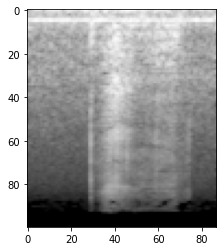

energy for type Circle_Scratches: 


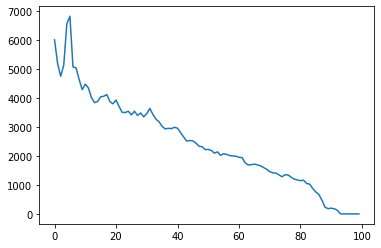

Type Fingernail_Taps, size (100, 65)


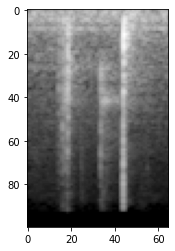

energy for type Fingernail_Taps: 


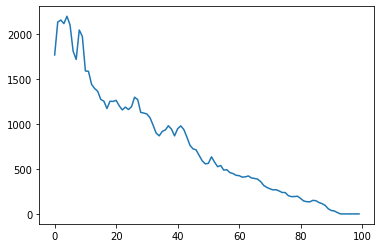

Type Fingertip_Taps, size (100, 65)


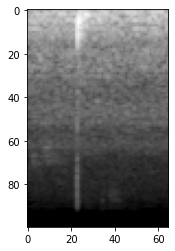

energy for type Fingertip_Taps: 


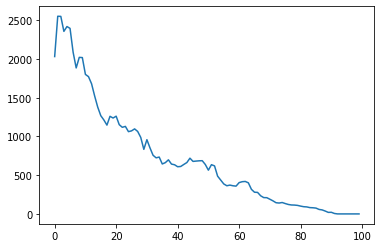

Type Silences, size (100, 65)


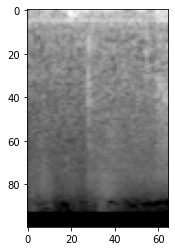

energy for type Silences: 


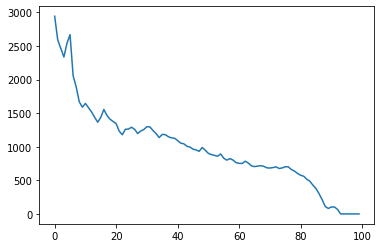

Type Vertical_Scratches, size (100, 65)


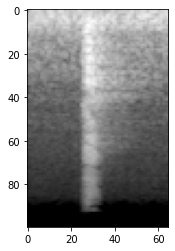

energy for type Vertical_Scratches: 


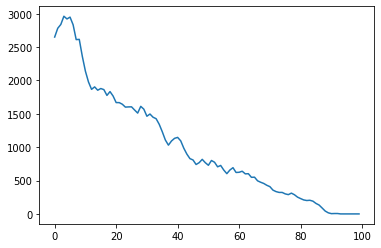

Type W_Scratches, size (100, 130)


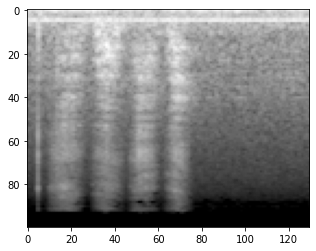

energy for type W_Scratches: 


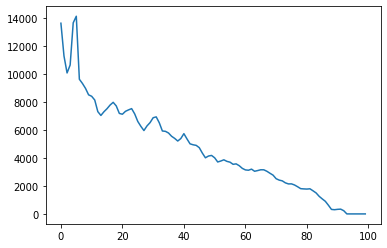

In [8]:
"""Getting All Images for Each Classes in Master Dict"""

mast_energy_list = [[],[],[],[],[],[]] # Same order as the above lists.

for i, folder in enumerate(folders):
    names = get_file_list(base_path, folder)
    ims = get_all_imgs(base_path+folder, names)
    print('Type {}, size {}'.format(folder, ims[0].shape))
    plt.imshow(ims[0], cmap='gray')
    plt.show()
    print('energy for type {}: '.format(folder))
    energies = []
    for im in ims:
        energy = get_freq(im)
        energies.append(energy)
    plt.plot(energies[0])
    plt.show()
    mast_energy_list[i] = energies

In [9]:
def downsample_X(X_full_sample, dimensionality, debug=False, normalize=True):
    # Downsampling: Adjusted to do one sample at a time
    X = np.zeros( [len(X_full_sample), dimensionality] )

    step_size = int(len(X_full_sample[0])/dimensionality)

    for ind in range(len(X_full_sample)):
        cnt = 0
        for j in range(0, len(X_full_sample[ind])-step_size, step_size):
            X[ind][cnt] = np.mean(X_full_sample[ind][j:j+step_size])

            cnt += 1
            
    if normalize:
        for i in range(X.shape[0]):
            X[i,:] /= max(X[i,:])

    if debug:
        plt.title('Full Resolution Vector')
        plt.plot(X_full_sample[0])
        plt.show()
        plt.title('Down Sampled (Averaged) Vector (Dimensionality: {})'.format(dimensionality))
        plt.plot(X[0])

    return X

In [10]:
"""Packaging master list of lists => Numpy Array X, Creating Label Array Y"""
Y = np.zeros([8784,1])

cnt=0
for i in range(len(mast_energy_list)):
    seg_len = len(mast_energy_list[i])
    Y[cnt:cnt+seg_len,:]=i
    cnt+=seg_len

concat_list = []

for l in mast_energy_list:
    concat_list+=l
    
X = np.asarray(concat_list)
for i in range(X.shape[0]):
    X[i,:] /= np.mean(X[i,:])

Shape of X: (8784, 100)
Shape of Y: (8784, 1)


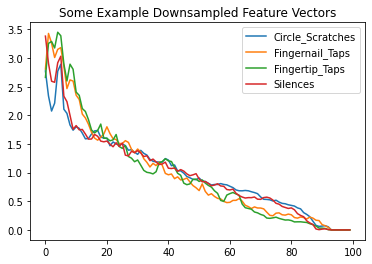

In [11]:
"""Double Checking the Input"""

print('Shape of X: {}'.format(X.shape))
print('Shape of Y: {}'.format(Y.shape))

plt.plot(X[1,:])
plt.plot(X[1440+1,:])
plt.plot(X[1440+1440+2,:])
plt.plot(X[1440+1440+1440+2,:])
plt.title('Some Example Downsampled Feature Vectors')
plt.legend([folders[int(Y[1][0])], 
            folders[int(Y[1440+1][0])], 
            folders[int(Y[1440+1440+2][0])],
            folders[int(Y[1440+1440+1440+2][0])]])
plt.show()

In [12]:
# Encoding Y as one-hot

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y_encoded = enc.transform(Y)

Y_encoded

<8784x6 sparse matrix of type '<class 'numpy.float64'>'
	with 8784 stored elements in Compressed Sparse Row format>

In [13]:
# Training Model

X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded,
                                                    random_state=1)
clf = MLPClassifier(random_state=1, max_iter=3000, hidden_layer_sizes=(100,)).fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("OVERALL SCORE OF MLP on TEST SET: {}".format(score))

score = clf.score(X_train, y_train)
print("\nOVERALL SCORE OF MLP on TRAIN SET: {}".format(score))

OVERALL SCORE OF MLP on TEST SET: 0.8119307832422586

OVERALL SCORE OF MLP on TRAIN SET: 0.8548876745598057


In [15]:
# Generating a Confusion Matrix
y_true = enc.inverse_transform(y_test)
y_pred = enc.inverse_transform(clf.predict(X_test))

for i in range(len(y_pred)):
    if y_pred[i][0] == None:
        y_pred[i][0] = 0
    
y_pred = y_pred.astype(int)

print("===================================================================")
print("=== RESULTS FOR FULL DATASET BASLINE MODEL -- FREQUENCY EDITION ===")
print("===================================================================\n")


print('\nTotal Dataset Size: \t\t{} Samples'.format(len(X)))
print('Total Training Set Size: \t{} Samples\nTotal Validation Set Size: \t{} Samples\n'.format(len(X_train), len(X_test)))

print('Test Set Confusion Matrix: {}'.format(folders))
print(confusion_matrix(y_true, y_pred))


y_true = enc.inverse_transform(y_train)
y_pred = enc.inverse_transform(clf.predict(X_train))
for i in range(len(y_pred)):
    if y_pred[i][0] == None:
        y_pred[i][0] = 0
    
y_pred = y_pred.astype(int)

print('\nTraining Set Confusion Matrix: {}'.format(folders))
print(confusion_matrix(y_true, y_pred))

score = clf.score(X_test, y_test)
print("\nOVERALL SCORE OF MLP on TEST SET: \t{}%".format(score*100))

score = clf.score(X_train, y_train)
print("OVERALL SCORE OF MLP on TRAIN SET: \t{}%".format(score*100))

=== RESULTS FOR FULL DATASET BASLINE MODEL -- FREQUENCY EDITION ===


Total Dataset Size: 		8784 Samples
Total Training Set Size: 	6588 Samples
Total Validation Set Size: 	2196 Samples

Test Set Confusion Matrix: ['Circle_Scratches', 'Fingernail_Taps', 'Fingertip_Taps', 'Silences', 'Vertical_Scratches', 'W_Scratches']
[[325   1   0   2   3   9]
 [ 54 291  12   2   0   1]
 [ 45  18 296   6   1   0]
 [ 31   5   8 373   3   1]
 [ 73   3   1   6 267   2]
 [ 57   1   0   1   6 292]]

Training Set Confusion Matrix: ['Circle_Scratches', 'Fingernail_Taps', 'Fingertip_Taps', 'Silences', 'Vertical_Scratches', 'W_Scratches']
[[1086    1    0    2    4    7]
 [ 131  917   21    6    4    1]
 [ 107   22  926   14    4    1]
 [  74    7    8 1058   10    6]
 [ 165    1    2   32  882    6]
 [ 160    1    0   10   20  892]]

OVERALL SCORE OF MLP on TEST SET: 	81.19307832422587%
OVERALL SCORE OF MLP on TRAIN SET: 	85.48876745598058%
